In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from ipywidgets import interact

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from inexact_psgla import *
from psgla import *
import distributions as pds
import potentials as pot

**Generate likelihood - differentiable part $F$ of the potential**\
Given clean image $u \in [0,1]^{128\times 128}$, we draw a noisy version $\tilde{u} \sim \mathrm{N}(u,\sigma^2 I)$ with variance $\sigma^2$ (determined from a given PSNR level). The noise model implies the Gaussian likelihood
$$ F(u) = \frac{1}{2\sigma^2}\lVert u-\tilde{u}\rVert_2^2. $$

Noise level: PSNR = 20.01095446966533


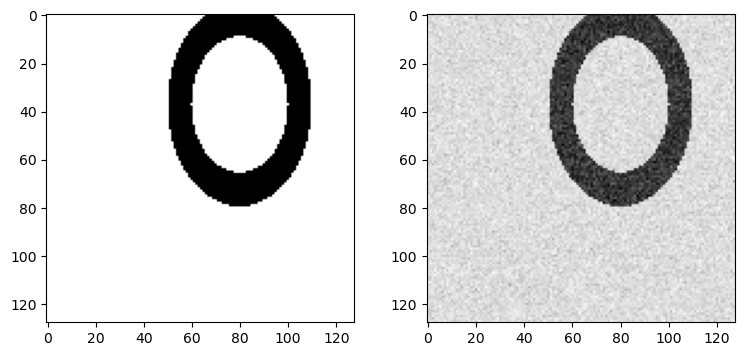

In [2]:
n1,n2 = 128,128
u = np.zeros((n1,n2))
for i1 in np.arange(n1):
    for i2 in np.arange(n2):
        R2 = 1/2*(i1-37)**2 + (i2-80)**2
        if R2 > 20**2 and R2 < 30**2:
            u[i1,i2] = 1
noise_psnr = 20 # [dB]
noise_std = 10**(-noise_psnr/20)
u_tilde = u + noise_std*rnd.normal(size=(n1,n2))
# check that psnr-std conversion was correct:
mse = np.mean((u_tilde-u)**2)
print('Noise level: PSNR = {}'.format(-10*np.log10(mse)))
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(u,cmap='Greys');
ax[1].imshow(u_tilde,cmap='Greys');

**Define the posterior distribution**\
We assume a TV prior, i.e. $u \sim \mu_{\text{prior}}$ for a measure $\mu_{\text{prior}}$ with Lebesgue density proportional to $\exp(-\lambda \mathrm{TV}(u))$.\
Then with Bayes' law, the posterior's Lebesgue density satisfies
$$ \frac{\mathrm{d}\mu_{\text{post}}}{\mathrm{d}\mathrm{Leb}}(u) \sim \exp\left(-\frac{1}{2}\lVert u-\tilde{u} \rVert_2^2 - \lambda \mathrm{TV}(u)\right) = \exp(-V(u))$$
with the individual terms $F(u) = \frac{1}{2}\lVert u-\tilde{u}\rVert_2^2$, $G(u) = \lambda \mathrm{TV}(u)$ and $V = F+G$ (the scaling $\sigma^2$ was absorbed into the parameter $\lambda$).\
\
The MAP estimator $\hat{u}$ is the mode of the posterior $\mu_{\text{post}}$ and can be computed by solving the ROF denoising problem
$$\hat{u} = \arg\min_u \left\{ \frac{1}{2}\lVert u-\tilde{u} \rVert_2^2 + \lambda \mathrm{TV}(u) \right\} = \mathrm{prox}_{\lambda\mathrm{TV}}(\tilde{u}).$$
We compute $\hat{u}$ just to check that the ROF implementation is correct: We solve the ROF problem by dualizing it and running proximal gradient descent on the dual problem until the duality gap is less than some $\epsilon$.

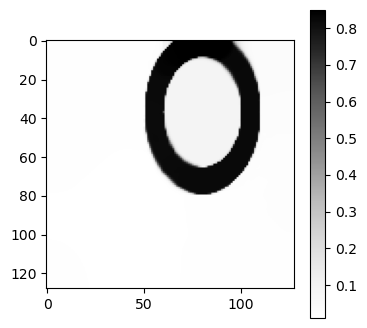

In [3]:
tvregROF = 1
TV = pot.TotalVariation_scaled(n1, n2, scale=tvregROF)
epsilonROF = 1e-4*n1*n2
maxiterROF = 1e4
u_hat = TV.inexact_prox(np.reshape(u_tilde,(-1,1)), tvregROF, epsilonROF, maxiterROF, verbose=False, gd_type='accelerated')
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.imshow(np.reshape(u_hat,(n1,n2)),cmap='Greys');
plt.colorbar()
# define the posterior distribution
posterior = pds.L2Loss_TVReg(n1*n2, np.reshape(u_tilde,(-1,1)), tvregROF, n1, n2)
L = 1 # Lipschitz constant of gradient of F
muF = 1 # strong convexity constant of F

**Sample once using iPSGLA with tiny step size and high accuracy to have something very close to the target for Wasserstein estimates**

In [4]:
# one run of PSGLA with tiny step size for Wasserstein distance comparison
tau_ref = 1/L*0.001
max_iter_ref = 10
n_samples_ref = 1
epsilon_ref = 1e-2
# initialize at the MAP to minimize burn-in time
u0_ref = np.reshape(u_hat,(-1,1))*np.ones((1,n_samples_ref))
ipsgla_almostgt = IPSGLA(max_iter_ref, tau_ref, u0_ref, epsilon_ref, pd = posterior)

x_almostgt = ipsgla_almostgt.simulate(return_all=True)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
x_almostgt.shape
fig,ax = plt.subplots(3,3,figsize=(20,15))
for i in range(9):
    ax[i//3,i%3].imshow(np.reshape(x_almostgt[:,0,-1-i],(n1,n2)),cmap='Greys');

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,15))
mean_samples = np.mean(x_almostgt,axis=2)
std_samples = np.std(x_almostgt,axis=2)
ax[0].imshow(np.reshape(mean_samples,(n1,n2)),cmap='Greys');
ax[1].imshow(np.reshape(std_samples,(n1,n2)),cmap='Greys');